In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("../reference_data/mbti_1.csv")

In [3]:
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [4]:
types = np.unique(data.type.values)
types

array(['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP',
       'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP'],
      dtype=object)

In [5]:
data.isnull().any()

type     False
posts    False
dtype: bool

In [6]:
nRow, nCol = data.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 8675 rows and 2 columns


In [7]:
row1posts = data.iloc[0, 1].split('|||')

In [8]:
len(row1posts)

50

In [9]:
types=list(types)
total = data.groupby(['type']).count()*50
total

,posts
type,
ENFJ,9500
ENFP,33750
ENTJ,11550
ENTP,34250
ESFJ,2100
ESFP,2400
ESTJ,1950
ESTP,4450
INFJ,73500


Text(0.5, 1.0, 'Total posts for each personality type')

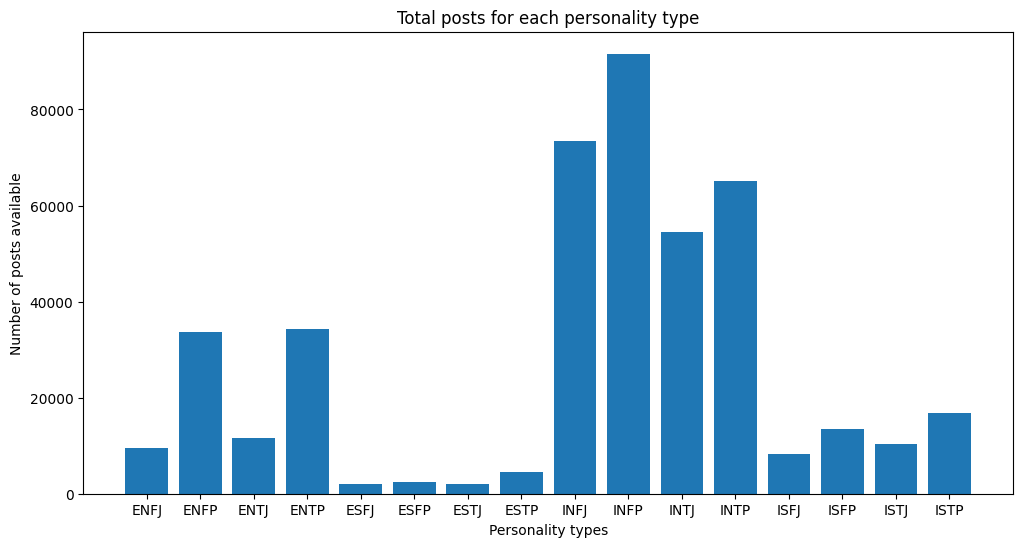

In [10]:
plt.figure(figsize=(12,6))
plt.bar(np.array(total.index), height = total['posts'],)
plt.xlabel('Personality types')
plt.ylabel('Number of posts available')
plt.title('Total posts for each personality type')

In [11]:
import re
import string

def text_preprocessing(text):
    regex = re.compile('[%s]' % re.escape('|')) # create a regex to match the '|' character in a string
    text = regex.sub(" ", text) # replace '|' with " "
    words = str(text).split() # creates a list of words
    words = [i.lower() + " " for i in words] # Lowercasing and Appending Space
    words = [i for i in words if not "http" in i] # removes http substring
    words = " ".join(words)
    words = words.translate(words.maketrans('', '', string.punctuation)) # removes punctuations
    return words

In [12]:
classes = {"I":0, "E":1, 
           "N":0,"S":1, 
           "T":0, "F":1, 
           "J":0,"P":1}

In [13]:
labels = []
for personality in data["type"]:
    pers_vect = []
    for p in personality:
        pers_vect.append(classes[p])
    labels.append(pers_vect)
    
sentences = data["posts"].apply(str).apply(lambda x: text_preprocessing(x))
labels = np.array(labels, dtype="float32")

In [14]:
sentences[0]

'enfp  and  intj  moments  sportscenter  not  top  ten  plays  pranks  what  has  been  the  most  lifechanging  experience  in  your  life  on  repeat  for  most  of  today  may  the  perc  experience  immerse  you  the  last  thing  my  infj  friend  posted  on  his  facebook  before  committing  suicide  the  next  day  rest  in  peace  hello  enfj7  sorry  to  hear  of  your  distress  its  only  natural  for  a  relationship  to  not  be  perfection  all  the  time  in  every  moment  of  existence  try  to  figure  the  hard  times  as  times  of  growth  as  84389  84390    welcome  and  stuff  game  set  match  prozac  wellbrutin  at  least  thirty  minutes  of  moving  your  legs  and  i  dont  mean  moving  them  while  sitting  in  your  same  desk  chair  weed  in  moderation  maybe  try  edibles  as  a  healthier  alternative  basically  come  up  with  three  items  youve  determined  that  each  type  or  whichever  types  you  want  to  do  would  more  than  likely  us

In [15]:
labels[0]

array([0., 0., 1., 0.], dtype=float32)

In [16]:
train_n=6624
val_n=1024
test_n=1024

train_sentences = sentences[:train_n]
y_train = labels[:train_n]

val_sentences = sentences[train_n:train_n+val_n]
y_val = labels[train_n:train_n+val_n]

test_sentences = sentences[train_n+val_n:train_n+val_n+test_n]
y_test = labels[train_n+val_n:train_n+val_n+test_n]

In [17]:
train_sentences

0       enfp  and  intj  moments  sportscenter  not  t...
1       im  finding  the  lack  of  me  in  these  pos...
2       good  one    of  course  to  which  i  say  i ...
3       dear  intp  i  enjoyed  our  conversation  the...
4       youre  fired  thats  another  silly  misconcep...
                              ...                        
6619    mmiddleton84  im  infp  according  to  the  pr...
6620    i  think  im  facing  a  burnout  of  some  ki...
6621    that  or  this  pretty  awesome  i  have  neve...
6622    i  tend  to  connect  actions  with  each  oth...
6623    counselor  your  interactive  orientation  emo...
Name: posts, Length: 6624, dtype: object

In [18]:
y_train

array([[0., 0., 1., 0.],
       [1., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [21]:
from transformers import TFBertModel, BertTokenizer

MAX_SEQ_LEN = 128
BERT_NAME = 'bert-base-uncased'

def prepare_bert_input(sentences, seq_len, bert_name):
    tokenizer = BertTokenizer.from_pretrained(bert_name) 
    encodings = tokenizer(sentences.tolist(), truncation=True, padding='max_length',
                                max_length=seq_len)
    
    # The tokenizer returns a dictionary
    # truncation=True: Truncate the sequences to fit the maximum length if they exceed it.
    
    
    input = [np.array(encodings["input_ids"]), np.array(encodings["token_type_ids"]),
               np.array(encodings["attention_mask"])]
    # the key input_ids are token indices, numerical representations of tokens
    # for encoding a single sentence, all token type IDs will be 0, for encoding a pair of sentences the token type IDs will distinguish between the tokens of the two sentences. 
    # attention mask indicates which tokens should be attended to and which ones should be ignored. Each 1 in the attention mask indicates a token that should be attended to, while each 0 indicates a token that should be ignored (typically padding tokens).

    return input

In [22]:
X_train = prepare_bert_input(train_sentences, MAX_SEQ_LEN, BERT_NAME)
X_val = prepare_bert_input(val_sentences, MAX_SEQ_LEN, BERT_NAME)
X_test = prepare_bert_input(test_sentences, MAX_SEQ_LEN, BERT_NAME)

In [25]:
#Model architecture
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.callbacks import ModelCheckpoint

N_AXIS = 4
input_ids = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='input_ids')
input_type = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='token_type_ids')
input_mask = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='attention_mask')
inputs = [input_ids, input_type, input_mask]

bert = TFBertModel.from_pretrained(BERT_NAME)
bert_outputs = bert(inputs)

last_hidden_states = bert_outputs.last_hidden_state
avg = layers.GlobalAveragePooling1D()(last_hidden_states)
output = layers.Dense(N_AXIS, activation="sigmoid")(avg)

model = keras.Model(inputs=inputs, outputs=output)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 token_type_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                              

In [ ]:
max_epochs = 8
batch_size = 32
opt = tfa.optimizers.RectifiedAdam(learning_rate=3e-5)
loss = keras.losses.BinaryCrossentropy()
best_weights_file = "bert_base_mode11.h5"
auc = keras.metrics.AUC(multi_label=True, curve="ROC")

m_ckpt = ModelCheckpoint(best_weights_file, monitor='val_'+auc.name, mode='max', verbose=2,
                          save_weights_only=True, save_best_only=True)

model.compile(loss=loss, optimizer=opt, metrics=[auc, keras.metrics.BinaryAccuracy()])

model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=max_epochs,
    batch_size=batch_size,
    callbacks=[m_ckpt],
    verbose=2
)

In [28]:
#After training, create a new model and load the weights

def recreate_model(): 
    input_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='input_ids')
    input_type = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='token_type_ids')
    input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='attention_mask')
    inputs = [input_ids, input_type, input_mask]
    bert = TFBertModel.from_pretrained(BERT_NAME)
    bert_outputs = bert(inputs)
    last_hidden_states = bert_outputs.last_hidden_state
    avg = tf.keras.layers.GlobalAveragePooling1D()(last_hidden_states)
    output = tf.keras.layers.Dense(N_AXIS, activation="sigmoid")(avg)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=output)
    loss = tf.keras.losses.BinaryCrossentropy()
    model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.00001), metrics=[keras.metrics.AUC(multi_label=True, curve="ROC"),
                                                  keras.metrics.BinaryAccuracy()])
    model.load_weights("bert_base_model1.h5")
    return model

In [29]:
new_model = recreate_model()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [30]:
predictions = new_model.predict(X_test)
new_model.evaluate(X_test, y_test, batch_size=32)

32/32 [==============================] - 158s 5s/step - loss: 0.4878 - auc_1: 0.7850 - binary_accuracy: 0.7681


[0.4877961277961731, 0.7849863767623901, 0.76806640625]

In [45]:
axes = ["I-E","N-S","T-F","J-P"]
input_text = "I'm feeling on top of the world right now. Who wants to celebrate with me? Let's make this event unforgettable; I've got some crazy ideas in mind!"
sentences = np.asarray([input_text])
enc_sentences = prepare_bert_input(sentences, MAX_SEQ_LEN, BERT_NAME)
predictions1 = new_model.predict(enc_sentences)

for sentence, pred in zip(sentences, predictions1):
    pred_axis = []
    mask = (pred > 0.5).astype(bool)
    for i in range(len(mask)):
        if mask[i]:
            pred_axis.append(axes[i][2])
        else:
            pred_axis.append(axes[i][0])
    print('-- comment: '+sentence.replace("\n", "").strip() +
        '\n-- personality: '+str(pred_axis) +
        '\n-- scores:'+str(pred))
result = ''.join(pred_axis)
print(result)

1/1 [==============================] - 0s 271ms/step
-- comment: I'm feeling on top of the world right now. Who wants to celebrate with me? Let's make this event unforgettable; I've got some crazy ideas in mind!
-- personality: ['I', 'N', 'F', 'P']
-- scores:[0.15022843 0.37541008 0.50061625 0.7907001 ]
INFP


In [48]:
from sklearn.metrics import auc, roc_curve

def plot_roc_auc(y_test, y_score, axes):
    plt.figure()
    for i in range(len(axes)):
        fpr, tpr, _ = roc_curve(y_test[:,i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve of class {0} (area = {1:0.2f})'.format(axes[i], roc_auc))
        # Compute micro-average ROC curve and ROC area
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

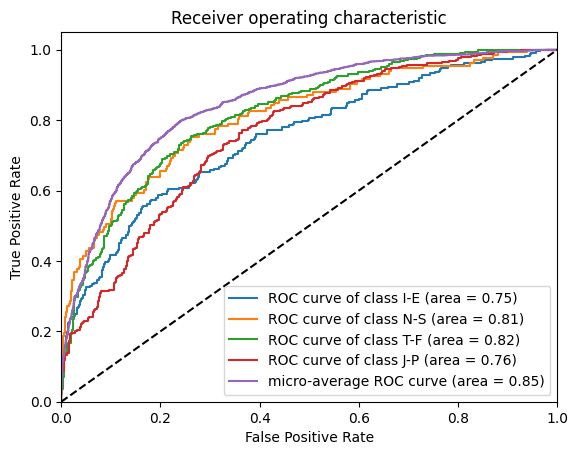

In [49]:
plot_roc_auc(y_test, predictions, axes)